# scBasset: Batch correction of scATACseq data

```{warning}
SCBASSET's development is still in progress. The current version may not fully reproduce the original implementation's results.
```

In addition to performing [representation learning on scATAC-seq data](https://docs.scvi-tools.org/en/latest/tutorials/notebooks/scbasset.html), scBasset can also be used to integrate data across several samples. This tutorial walks through the following:

1. Loading the dataset
1. Preprocessing the dataset with `scanpy`
1. Setting up and training the model
1. Visualizing the batch-corrected latent space with `scanpy`
1. Quantifying integration performance with `scib-metrics`

In [ ]:
!pip install --quiet scvi-colab
!pip install --quiet scib-metrics
from scvi_colab import install

install()

In [1]:
import matplotlib.pyplot as plt
import scanpy as sc
import scvi
from scib_metrics.benchmark import Benchmarker

scvi.settings.seed = 0
sc.set_figure_params(figsize=(4, 4), frameon=False)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

Global seed set to 0
Global seed set to 0


In [ ]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

## Loading the dataset

We will use the dataset from [Buenrostro et al., 2018](https://pubmed.ncbi.nlm.nih.gov/29706549/) throughout this tutorial, which contains single-cell chromatin accessibility profiles across 10 populations of human hematopoietic cell types.

In [2]:
adata = sc.read(
    "data/buen_ad_sc.h5ad",
    backup_url="https://storage.googleapis.com/scbasset_tutorial_data/buen_ad_sc.h5ad",
)
adata

AnnData object with n_obs × n_vars = 2034 × 103151
    obs: 'cell_barcode', 'label', 'batch'
    var: 'chr', 'start', 'end', 'n_cells'
    uns: 'label_colors'

We see that batch information is stored in `adata.obs["batch"]`. In this case, batches correspond to different donors.

In [3]:
BATCH_KEY = "batch"
adata.obs[BATCH_KEY].value_counts()

BM0828    533
BM1077    507
BM1137    402
BM1214    298
BM0106    203
other      91
Name: batch, dtype: int64

We also have author-provided cell type labels available.

In [4]:
LABEL_KEY = "label"
adata.obs[LABEL_KEY].value_counts()

CMP     502
GMP     402
HSC     347
LMPP    160
MPP     142
pDC     141
MEP     138
CLP      78
mono     64
UNK      60
Name: label, dtype: int64

## Preprocessing the dataset

We now use `scanpy` to preprocess the data before giving it to the model. In our case, we filter out peaks that are rarely detected (detected in less than 5% of cells) in order to make the model train faster.

In [5]:
print("before filtering:", adata.shape)
min_cells = int(adata.n_obs * 0.05)  # threshold: 5% of cells
sc.pp.filter_genes(adata, min_cells=min_cells)  # in-place filtering of regions
print("after filtering:", adata.shape)

before filtering: (2034, 103151)
after filtering: (2034, 33247)


Taking a look at `adata.var`, we see that this dataset has already been processed to include the `start` and `end` positions of each peak, as well as the chromosomes on which they are located.

In [6]:
adata.var.sample(10)

,chr,start,end,n_cells
218963,chr8,121761544,121762104,107
227586,chr9,117167843,117168397,125
223385,chr9,34986390,34987016,470
90362,chr17,15602531,15603282,542
48102,chr12,14537791,14538412,111
83864,chr16,29634123,29634443,110
206831,chr7,112030880,112032276,390
176756,chr5,72143780,72145204,363
100447,chr18,29599335,29600153,265
23121,chr10,11217571,11218248,102


We will use this information to add DNA sequences into `adata.varm`. This can be performed in-place with `scvi.data.add_dna_sequence`.

In [7]:
scvi.data.add_dna_sequence(
    adata,
    chr_var_key="chr",
    start_var_key="start",
    end_var_key="end",
    genome_name="hg19",
    genome_dir="data",
)
adata

Working...: 100%|██████████| 24/24 [00:01<00:00, 13.53it/s]


AnnData object with n_obs × n_vars = 2034 × 33247
    obs: 'cell_barcode', 'label', 'batch'
    var: 'chr', 'start', 'end', 'n_cells'
    uns: 'label_colors'
    varm: 'dna_sequence', 'dna_code'

The function adds two new fields into `adata.varm`: `dna_sequence`, containing bases for each position, and `dna_code`, containing bases encoded as integers.

In [8]:
adata.varm["dna_sequence"]

,0,1,2,3,4,5,6,7,8,9,...,1324,1325,1326,1327,1328,1329,1330,1331,1332,1333
0,N,N,N,N,N,N,N,N,N,N,...,C,T,T,G,C,A,G,C,C,G
3,C,A,C,T,C,A,A,G,G,A,...,G,G,G,C,T,C,A,G,A,A
5,A,A,T,T,C,C,G,G,G,T,...,C,T,C,A,C,C,T,T,G,G
8,G,T,T,T,A,C,A,G,T,T,...,C,T,A,A,G,C,C,A,C,C
9,T,C,A,T,G,T,T,G,C,C,...,G,T,T,T,C,A,C,T,G,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237371,G,G,C,T,G,C,A,A,G,G,...,T,T,T,G,A,G,A,C,C,A
237383,A,A,G,C,T,G,A,A,A,G,...,T,C,A,T,T,G,C,T,C,T
237399,C,A,T,G,A,T,T,T,A,T,...,T,C,C,C,T,T,T,T,C,C
237425,T,G,C,T,A,G,G,T,T,G,...,C,C,T,T,T,T,T,G,A,A


## Setting up and training the model

Now, we are readyto register our data with `scvi`. We set up our data with the model using `setup_anndata`, which will ensure everything the model needs is in place for training.

In this stage, we can condition the model on covariates, which encourages the model to remove the impact of those covariates from the learned latent space. Since we are integrating our data across donors, we set the `batch_key` argument to the key in `adata.obs` that contains donor information (in our case, just `"batch"`).

Additionally, since scBasset considers training mini-batches across regions rather than observations, we transpose the data prior to giving it to the model. The model also expects binary accessibility data, so we add a new layer with binary information.

In [9]:
bdata = adata.transpose()
bdata.layers["binary"] = (bdata.X.copy() > 0).astype(float)
scvi.external.SCBASSET.setup_anndata(
    bdata, layer="binary", dna_code_key="dna_code", batch_key=BATCH_KEY
)

INFO     Using column names from columns of adata.obsm['dna_code']                                                 


We now create the model. We use a non-default argument (`l2_reg_cell_embedding`), which is designed to aid integration of scATAC-seq data.

In [10]:
model = scvi.external.SCBASSET(bdata, l2_reg_cell_embedding=1e-8)
model.view_anndata_setup()

Anndata setup with scvi-tools version 0.20.0b1.

Setup via `SCBASSET.setup_anndata` with arguments:

{'dna_code_key': 'dna_code', 'layer': 'binary', 'batch_key': 'batch'}

     Summary Statistics     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Summary Stat Key ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│     n_batch      │   6   │
│     n_cells      │ 33247 │
│    n_dna_code    │ 1334  │
│      n_vars      │ 2034  │
└──────────────────┴───────┘

               Data Registry               
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃   scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['binary']  │
│    batch     │ adata.var['_scvi_batch'] │
│   dna_code   │  adata.obsm['dna_code']  │
└──────────────┴──────────────────────────┘

                  batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.var['batch'] │   BM0106   │          0          │
│                    │   BM0828   │          1          │
│                    │   BM1077   │          2          │
│                    │   BM1137   │          3          │
│                    │   BM1214   │          4          │
│                    │   other    │          5          │
└────────────────────┴────────────┴─────────────────────┘

In [11]:
model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1000/1000: 100%|██████████| 1000/1000 [2:08:34<00:00,  7.71s/it, loss=0.32, v_num=1] 

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 1000/1000: 100%|██████████| 1000/1000 [2:08:34<00:00,  7.71s/it, loss=0.32, v_num=1]


<AxesSubplot: xlabel='epoch'>

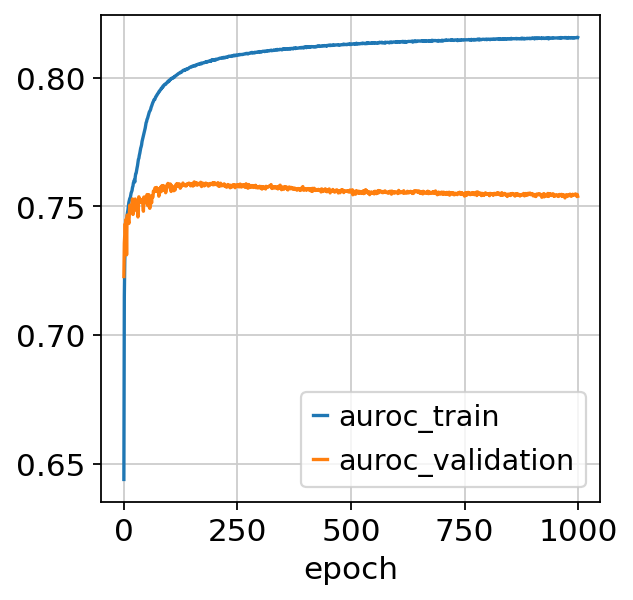

In [12]:
fig, ax = plt.subplots()
model.history_["auroc_train"].plot(ax=ax)
model.history_["auroc_validation"].plot(ax=ax)

## Visualizing the batch-corrected latent space

After training, we retrieve the integrated latent space and save it into `adata.obsm`.

In [13]:
LATENT_KEY = "X_scbasset"
adata.obsm[LATENT_KEY] = model.get_latent_representation()
adata.obsm[LATENT_KEY].shape

(2034, 32)

Now, we use `scanpy` to visualize the latent space by first computing the k-nearest-neighbor graph and then computing its TSNE representation with parameters to reproduce the original scBasset tutorial for this dataset.

In [14]:
sc.pp.neighbors(adata, use_rep=LATENT_KEY)
sc.tl.umap(adata, min_dist=1.0)

/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


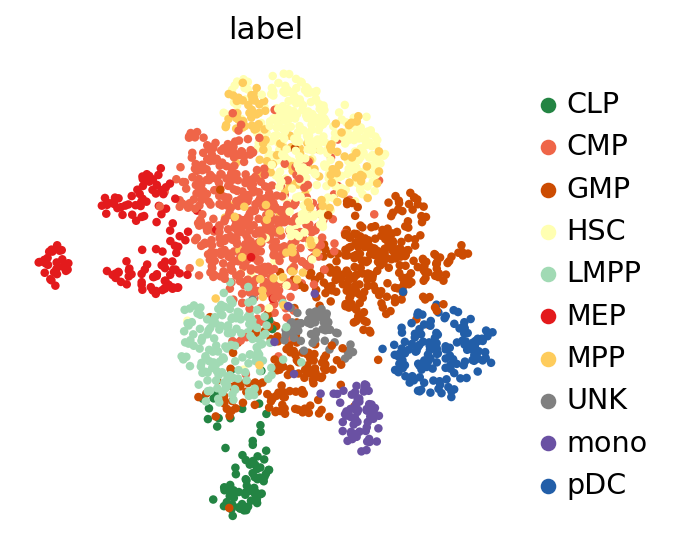

In [15]:
sc.pl.umap(adata, color=LABEL_KEY)

/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


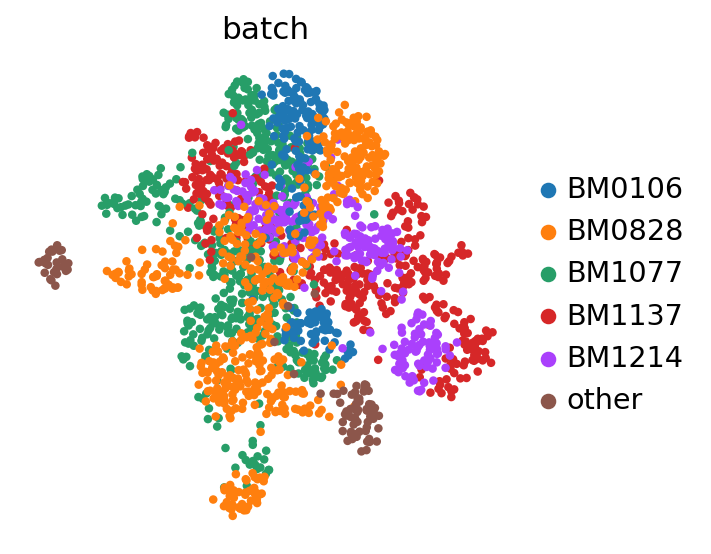

In [16]:
sc.pl.umap(adata, color=BATCH_KEY)

## Quantifying integration performance

Here we use the [scib-metrics](https://scib-metrics.readthedocs.io/en/stable/) package, which contains scalable implementations of the metrics used in the scIB benchmarking suite. We can use these metrics to assess the quality of the integration.

In [17]:
bm = Benchmarker(
    adata,
    batch_key=BATCH_KEY,
    label_key=LABEL_KEY,
    embedding_obsm_keys=[LATENT_KEY],
    n_jobs=-1,
)
bm.benchmark()

Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]

INFO     UNK consists of a single batch or is too small. Skip.                                                     
INFO     mono consists of a single batch or is too small. Skip.                                                    


/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/scib_metrics/_pcr_comparison.py:49: UserWarning: PCR comparison score is negative, meaning variance contribution increased after integration. Setting to 0.
  warnings.warn(
Embeddings: 100%|██████████| 1/1 [00:13<00:00, 13.27s/it]


In [18]:
df = bm.get_results(min_max_scale=False)
df

,Isolated labels,Leiden NMI,Leiden ARI,Silhouette label,cLISI,Silhouette batch,iLISI,KBET,Graph connectivity,PCR comparison,Batch correction,Bio conservation,Total
Embedding,,,,,,,,,,,,,
X_scbasset,0.509493,0.701717,0.586483,0.51258,0.952968,0.870375,0.106045,0.088347,0.838808,0,0.380715,0.652648,0.543875
Metric Type,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Batch correction,Batch correction,Batch correction,Batch correction,Batch correction,Aggregate score,Aggregate score,Aggregate score
